# Download Planet Imagery

This notebook shows how to download planet imagery using the Planet API using the validation table.

In [1]:
import geopandas as gpd
from planet import api
from planet.api import downloader
from planet.api.downloader import create
import os
import rasterio
from pathlib import Path
from dotenv import dotenv_values
from rasterio.plot import show
import matplotlib.pyplot as plt
import pandas as pd

/Users/cmarshak/opt/anaconda3/envs/dswx_val/lib/python3.10/site-packages/planet/api/__init__.py:38: ClientV1DeprecationWarning: The planet.api module is deprecated and will be removed in version 2.0.0. For more details please see the discussion at https://github.com/planetlabs/planet-client-python/discussions.
  warnings.warn(


# Parameters

Specify *exactly* one. The `site_name` or the `planet_id`. The former is given to the chip by the validation team. Because we are not selecting multiple planet scenes per chip and not selecting planet images that cover multiple chips (they are sufficiently spaced apart), this should be a 1 to 1 mapping.

In [2]:
PLANET_ID = ''
SITE_NAME = '3_28'

# ^ is exclusive or; makes sure you only specified one
assert((len(PLANET_ID) == 0) ^ (len(SITE_NAME) == 0))

# Environment

Ensure we can make AWS anonymous requests and obtain the planet API key.

In [3]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"

config = dotenv_values()
PLANET_API_KEY = config['PLANET_API_KEY']

# Get Image Database

In [4]:
df_images = gpd.read_file('s3://opera-calval-database-dswx/image.geojson')
df_images.dropna(inplace=True)
df_images.head()

,collocated_dswx,dswx_cloud_cover,datetime,image_name,cloud_cover,site_coverage,instrument,provider,resolution,timeDelta_days,site_name,Strata,geometry
0,HLS.S30.T04WDB.2021271T225541.v2.0,4.0,2021-09-29 21:28:09.168000+00:00,20210929_212809_16_2442,0.0,90.820013,PSB.SD,planetscope,3.0,0.938606,3_38,3.0,"POLYGON ((-160.00896 69.30478, -160.21043 69.1..."
1,HLS.S30.T33WXP.2021270T104719.v2.0,16.0,2021-09-27 09:55:37.877000+00:00,20210927_095537_0f15,0.0,41.216128,PS2,planetscope,3.0,0.039303,4_43,4.0,"POLYGON ((17.22275 66.09223, 17.16459 66.02168..."
2,HLS.L30.T40WFU.2021268T073033.v2.0,2.0,2021-09-25 07:27:12.166000+00:00,20210925_072712_16_2254,0.0,72.272530,PSB.SD,planetscope,3.0,0.002335,3_1,3.0,"POLYGON ((59.00446 65.95517, 58.85023 65.76646..."
3,HLS.S30.T14VPQ.2021244T175911.v2.0,2.0,2021-09-01 17:52:05.712000+00:00,20210901_175205_71_2426,0.0,100.000000,PSB.SD,planetscope,3.0,0.010000,4_34,4.0,"POLYGON ((-96.94381 62.88876, -97.07609 62.707..."
4,HLS.S30.T52VFP.2021253T023549.v2.0,2.0,2021-09-11 00:51:29.821000+00:00,20210911_005129_82_106a,0.0,100.000000,PS2.SD,planetscope,3.0,0.924389,3_30,3.0,"POLYGON ((130.86458 61.50211, 130.95358 61.357..."


In [5]:
temp = df_images[['image_name', 'site_name']]
df_site2image = temp.set_index('site_name')
df_image2site = temp.set_index('image_name')
df_site2image.head()

,image_name
site_name,
3_38,20210929_212809_16_2442
4_43,20210927_095537_0f15
3_1,20210925_072712_16_2254
4_34,20210901_175205_71_2426
3_30,20210911_005129_82_106a


In [6]:
if not PLANET_ID:
    values = PLANET_ID = df_site2image.loc[SITE_NAME].tolist()
    PLANET_ID = values[0]
    print(f'There was {len(values)} planet images for this chip')
else:
    values = df_image2site.loc[PLANET_ID].tolist()
    SITE_NAME = values[0]
    print(f'There were {len(values)} chips for this planet_image')

(SITE_NAME, PLANET_ID)

There was 1 planet images for this chip


('3_28', '20210906_101112_28_225a')

In [7]:
data_dir = Path(f'data/{PLANET_ID}/')
data_dir.mkdir(exist_ok=True, parents=True)

# Download

These are async functions. You will not only have to interrupt the kernel, but also run `downloader.shutdown()` to re-run this section. Currently, they are commented out.

In [8]:
ITEM_TYPE = 'PSScene'
ASSET_TYPES = ['ortho_analytic_8b_sr', 
               'ortho_analytic_8b_xml']

In [9]:
from planet.api import downloader

client = api.ClientV1(api_key=PLANET_API_KEY)
downloader = downloader.create(client)
downloader

In [10]:
req = client.get_item(ITEM_TYPE, 
                      PLANET_ID)
resp = req.get()
resp['assets']

['basic_analytic_4b',
 'basic_analytic_4b_rpc',
 'basic_analytic_4b_xml',
 'basic_analytic_8b',
 'basic_analytic_8b_xml',
 'basic_udm2',
 'ortho_analytic_4b',
 'ortho_analytic_4b_sr',
 'ortho_analytic_4b_xml',
 'ortho_analytic_8b',
 'ortho_analytic_8b_sr',
 'ortho_analytic_8b_xml',
 'ortho_udm2',
 'ortho_visual']

In [11]:
items_to_download = [resp] * len(ASSET_TYPES)

In [12]:
resp_ac = downloader.activate(iter(items_to_download), ASSET_TYPES)
resp_ac

{'paging': False, 'activating': 0, 'pending': 0, 'complete': 2}

In [13]:
#downloader.shutdown()

In [14]:
resp_dl = downloader.download(iter(items_to_download), ASSET_TYPES, str(data_dir))
resp_dl

`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead
`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead
`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead
`background_callback` is deprecated and will be removed in 1.0, use `hooks` instead


{'paging': False,
 'activating': 0,
 'pending': 0,
 'complete': 4,
 'downloading': 0,
 'downloaded': '2127.39MB'}

In [15]:
#downloader.shutdown()

# Check (optional)

Let's check the extent of the image tables with the image we downloaded. They should align. 

In [16]:
n = len(PLANET_ID)
planet_images = list(data_dir.glob('*.tif'))
planet_image_path = list(filter(lambda x: x.name[:n] == PLANET_ID, planet_images))[0]
planet_image_path

PosixPath('data/20210906_101112_28_225a/20210906_101112_28_225a_3B_AnalyticMS_SR_8b.tif')

In [17]:
import numpy as np

with rasterio.open(planet_image_path) as ds:
    planet_crs = ds.crs
    full_planet_image = ds.read(1).astype(float)
    nodata = ds.nodata
    profile = ds.profile
    
full_planet_image[full_planet_image == nodata] = np.nan

In [18]:
df_image = df_images[df_images.image_name == PLANET_ID]
df_image_utm = df_image.to_crs(planet_crs)

<AxesSubplot:>

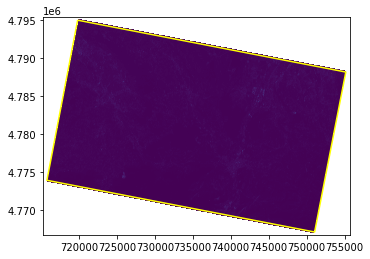

In [19]:
fig, ax = plt.subplots()
show(full_planet_image, transform=profile['transform'], ax=ax)
df_image_utm.boundary.plot(ax=ax, color='yellow')

The yellow line is the boundary of the image in the table.